# CS-GY 6953 Deep Learning Mini-Project Learning Rate

Task: Building a ResNet model on CIFAR-10 with a constraint of 5 million parameters maximum.

In this notebook, when I refer to a paper, it is about the ResNet paper: https://arxiv.org/abs/1512.03385 <br>
Codes are developed based on the excellent work here: https://github.com/kuangliu/pytorch-cifar

## 1. Objective
In the models in the github repo, the learning rate is set to 0.1 and the CosineAnnealingLR is used to manipulate the learning rate during the training. However, one method mentioned in the paper is fixing the learning rate to 0.1, then dividing it by 10 at 32,000 and 48,000 iterations. So, it worth trying different learning rate scheduling and checking what strategy works better for this image classification task.

## 2. CosineAnnealingLR
Since this scheduler was new to me, let's start clarifying what this is actually doing. The detailed documentation is here: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html <br>
It says that if the learning rate is determined only by this scheduler, the following holds.
$$ \eta_t = \eta_{\min} + \frac{1}{2} (\eta_{\max} - \eta_{\min}) \left(1+\cos\left( \frac{T_{\text{cur}}}{T_{\max}}\pi \right) \right) $$ 
In the github repo's code, they set the initial learning rate to 0.1 and $T_{\max} = 200$. Following this, the learning rate will be changed as follows.

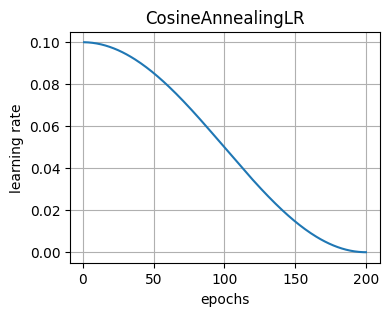

In [1]:
import numpy as np
import matplotlib.pyplot as plt

eta = [0.1]
t_max = 200
eta_min = 0
for t_cur in range(1,t_max+1):
    eta_t = eta_min + 1/2*(max(eta) - eta_min) * (1 + np.cos(t_cur/t_max*np.pi))
    eta.append(eta_t)

plt.figure(figsize=(4,3))
plt.plot(np.arange(1,t_max+1), eta[1:])
plt.title("CosineAnnealingLR")
plt.xlabel("epochs")
plt.ylabel("learning rate")
plt.grid()
plt.show()

As the name suggests, the learning rate will be decreased by following the cosine curve to zero.

## 3. Comparison between CosineAnnealingLR and ReduceLROnPlateau
As it may impossible for us to train 32,000 iterations and divide the learning rate by 10, we will use the RecudeLROnPlateau to control the learning rate. Specifically, our scheduler will monitor the test accuracy and if there is no improvement in consecutive 10 epochs, then will cut the learning rate.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchsummary import summary

import os

In [4]:
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# There are more functions for augmentation.
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The device is {device}.")

The device is cuda.


In [6]:
class BasicBlock(nn.Module): # A residual block with 2 convolutional layers and a skip connection.
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1, identity_skip=False): # Add identity_skip parameter.
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes,      # Number of channels in the input image
                               planes,         # Number of output channels
                               kernel_size=3,  # Size of the convolution filter
                               stride=stride,  # Stride of the convolution
                               padding=1,      # Padding added to all four sides of the input, int or {'valid', 'same'}, etc.
                               # padding_mode={'zeros', 'reflect', 'replicate', 'circular'}
                               bias=False)     # If true, adds a learnable bias ot the output.
        self.bn1 = nn.BatchNorm2d(planes)      # Other parameters include eps, momentum, affine, etc.
                                               # affine=True: affine parameters being learnable.
        self.conv2 = nn.Conv2d(planes, 
                               planes, 
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()        # A sequentil wrapper of layers.
        # If the dimentions of skip connection input and output don't match, do the following.
        # As an alternative solution, zero-padding is also proposed in the paper.
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, 
                                                    self.expansion*planes, 
                                                    kernel_size=1, 
                                                    stride=stride, 
                                                    bias=False),
                                          nn.BatchNorm2d(self.expansion*planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [7]:
def train(epoch):
    if (epoch+1) % 10 == 0:
        print('\nEpoch: %d'%epoch)
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for (inputs, targets) in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    train_loss /= total
    if (epoch+1) % 10 == 0:
        print(f"Train | Loss: {round(train_loss, 4)} | Acc: {round(acc, 2)}")
    train_losses.append(train_loss)
    train_accs.append(acc)

def test(epoch):
    global train_losses, test_losses, train_accs, test_accs, best_acc, best_model
    model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for (inputs, targets) in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    test_loss /= total
    if (epoch+1) % 10 == 0:
        print(f"Test  | Loss: {round(test_loss, 4)} | Acc: {round(acc, 2)}")
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    if acc > best_acc:
        best_model = model.state_dict()
        best_acc = acc

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32
        
        self.conv1 = nn.Conv2d(3, 32, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 96, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 120, num_blocks[3], stride=2)
        self.linear = nn.Linear(120*block.expansion, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes*block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [9]:
model_example = ResNet(BasicBlock, [2,2,2,2]).to(device)
summary(model_example, (3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

In [12]:
if not os.path.isdir('checkpoint_lr'):
    os.mkdir('checkpoint_lr')
    models = {}

First, training the model with the CosineAnnealingLR.

In [37]:
model = ResNet(BasicBlock, [2,2,2,2]).to(device)
    
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.1, 
                      momentum=0.9, 
                      weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

train_losses = []
test_losses = []
train_accs = []
test_accs = []
lrs = []

num_epochs = 100
best_acc = 0
best_model = model.state_dict()
models["CosineAnnealingLR"] = {}
for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()
models["CosineAnnealingLR"]["model"] = best_model
models["CosineAnnealingLR"]["train_loss"] = train_losses
models["CosineAnnealingLR"]["test_loss"] = test_losses
models["CosineAnnealingLR"]["train_acc"] = train_accs
models["CosineAnnealingLR"]["test_acc"] = test_accs
models["CosineAnnealingLR"]["lr"] = lrs
models["CosineAnnealingLR"]["epoch"] = epoch
torch.save(models, './checkpoint_lr/ckpt.pth')


Epoch: 9
Train | Loss: 0.0041 | Acc: 81.88
Test  | Loss: 0.0056 | Acc: 76.72

Epoch: 19
Train | Loss: 0.0034 | Acc: 85.0
Test  | Loss: 0.0048 | Acc: 79.81

Epoch: 29
Train | Loss: 0.003 | Acc: 86.94
Test  | Loss: 0.0044 | Acc: 81.81

Epoch: 39
Train | Loss: 0.0026 | Acc: 88.44
Test  | Loss: 0.0039 | Acc: 83.29

Epoch: 49
Train | Loss: 0.0022 | Acc: 90.14
Test  | Loss: 0.0032 | Acc: 87.31

Epoch: 59
Train | Loss: 0.0018 | Acc: 92.2
Test  | Loss: 0.0032 | Acc: 86.88

Epoch: 69
Train | Loss: 0.0012 | Acc: 94.76
Test  | Loss: 0.0025 | Acc: 90.1

Epoch: 79
Train | Loss: 0.0006 | Acc: 97.51
Test  | Loss: 0.002 | Acc: 92.08

Epoch: 89
Train | Loss: 0.0002 | Acc: 99.47
Test  | Loss: 0.0019 | Acc: 93.45

Epoch: 99
Train | Loss: 0.0001 | Acc: 99.78
Test  | Loss: 0.0019 | Acc: 93.94


Second, train the model with the ReduceLROnPlateau.

In [15]:
model = ResNet(BasicBlock, [2,2,2,2]).to(device)
    
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.1, 
                      momentum=0.9, 
                      weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=15)

train_losses = []
test_losses = []
train_accs = []
test_accs = []
lrs = []

num_epochs = 100
best_acc = 0
best_model = model.state_dict()
models["ReduceLROnPlateau"] = {}
for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(test_accs[-1])
models["ReduceLROnPlateau"]["model"] = best_model
models["ReduceLROnPlateau"]["train_loss"] = train_losses
models["ReduceLROnPlateau"]["test_loss"] = test_losses
models["ReduceLROnPlateau"]["train_acc"] = train_accs
models["ReduceLROnPlateau"]["test_acc"] = test_accs
models["ReduceLROnPlateau"]["lr"] = lrs
models["ReduceLROnPlateau"]["epoch"] = epoch
torch.save(models, './checkpoint_lr/ckpt.pth')


Epoch: 9
Train | Loss: 0.0041 | Acc: 81.83
Test  | Loss: 0.0069 | Acc: 72.66

Epoch: 19
Train | Loss: 0.0035 | Acc: 84.6
Test  | Loss: 0.0063 | Acc: 75.13

Epoch: 29
Train | Loss: 0.0033 | Acc: 85.46
Test  | Loss: 0.0045 | Acc: 81.59

Epoch: 39
Train | Loss: 0.0032 | Acc: 85.88
Test  | Loss: 0.0049 | Acc: 80.42

Epoch: 49
Train | Loss: 0.0031 | Acc: 86.54
Test  | Loss: 0.0038 | Acc: 83.82

Epoch: 59
Train | Loss: 0.0019 | Acc: 91.75
Test  | Loss: 0.0021 | Acc: 90.89

Epoch: 69
Train | Loss: 0.0009 | Acc: 96.32
Test  | Loss: 0.0021 | Acc: 91.8

Epoch: 79
Train | Loss: 0.0007 | Acc: 96.88
Test  | Loss: 0.0023 | Acc: 91.54

Epoch: 89
Train | Loss: 0.0003 | Acc: 98.97
Test  | Loss: 0.0019 | Acc: 92.85

Epoch: 99
Train | Loss: 0.0002 | Acc: 99.35
Test  | Loss: 0.002 | Acc: 93.02


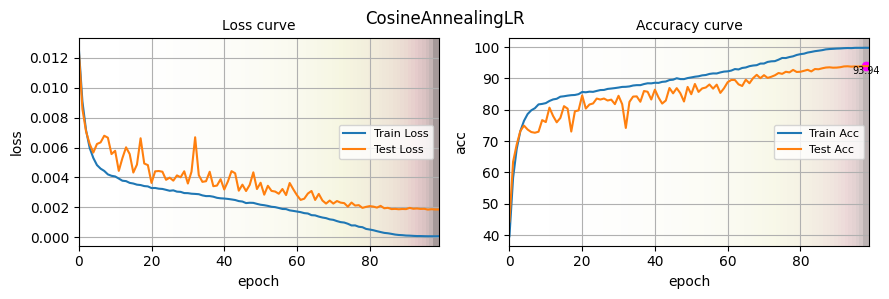

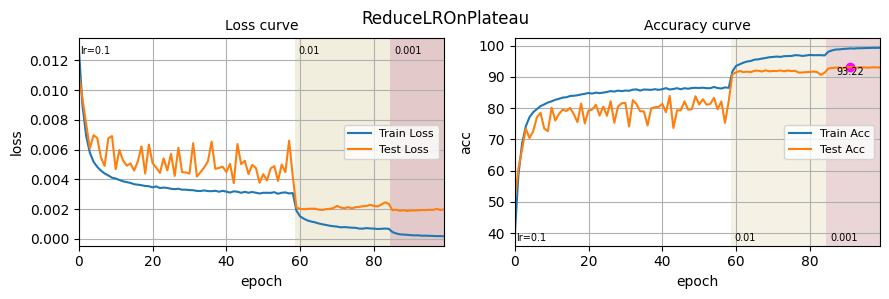

In [5]:
num_epochs = 100
models = torch.load('./checkpoint_lr/ckpt.pth', map_location=device)
xax = range(num_epochs)
names = ["CosineAnnealingLR", "ReduceLROnPlateau"]
for i in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(9,3))
    axs[0].plot(xax, models[names[i]]["train_loss"], label="Train Loss")
    axs[0].plot(xax, models[names[i]]["test_loss"], label="Test Loss")
    axs[0].set_title('Loss curve', fontsize=10)
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].grid()
    axs[0].legend(loc="center right", fontsize=8)
    lr = models[names[i]]["lr"]
    axs[0].pcolorfast(xax, axs[0].get_ylim(), np.log(np.array(lr))[np.newaxis], cmap="pink", alpha=0.4, vmax=np.log(1e-1), vmin=np.log(1e-4))
    if i == 1:
        l = 1
        for j in xax:
            if lr[j] != l:
                l = lr[j]
                if j == 0:
                    axs[0].text(j+0.5, axs[0].get_ylim()[1]-0.0005, f"lr={round(l,6)}", fontsize=7, va="top")
                else:
                    axs[0].text(j+0.5, axs[0].get_ylim()[1]-0.0005, f"{round(l,6)}", fontsize=7, va="top")
            
    axs[1].plot(xax, models[names[i]]["train_acc"], label="Train Acc")
    axs[1].plot(xax, models[names[i]]["test_acc"], label="Test Acc")
    best_epoch, best_val = np.argmax(models[names[i]]["test_acc"]), max(models[names[i]]["test_acc"])
    axs[1].scatter(best_epoch, best_val, marker="o", c="magenta")
    axs[1].text(best_epoch, best_val, round(best_val, 2), va="top", ha="center", fontsize=7)
    axs[1].set_title('Accuracy curve', fontsize=10)
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('acc')
    axs[1].grid()
    axs[1].legend(loc="center right", fontsize=8)
    lr = models[names[i]]["lr"]
    axs[1].pcolorfast(xax, axs[1].get_ylim(), np.log(np.array(lr))[np.newaxis], cmap="pink", alpha=0.3, vmax=np.log(1e-1), vmin=np.log(1e-4))
    if i == 1:
        l = 1
        for j in xax:
            if lr[j] != l:
                l = lr[j]
                if j == 0:
                    axs[1].text(j+0.5, axs[1].get_ylim()[0]+1, f"lr={round(l,6)}", fontsize=7, va="bottom")
                else:
                    axs[1].text(j+0.5, axs[1].get_ylim()[0]+1, f"{round(l,6)}", fontsize=7, va="bottom")
    fig.tight_layout()
    fig.suptitle(names[i])
    fig.show()

Comparing the test aaccuracy, the CosineAnnealingLR has a slightly better performance of 93.94% while the ReduceLROnPlateau gets 93.22%. In the ReduceLROnPlateau, the loss dropped and accuracy rose significantly right after cutting the learning rate. The CosineAnnealingLR, however, as it reduces the learning rate gradually in each epoch, there is no jump in the plots above. Let's compare how the training has done.

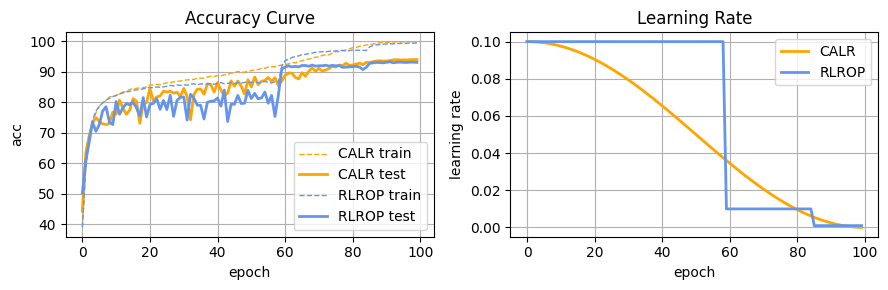

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(9,3))
axs[0].plot(xax, models["CosineAnnealingLR"]["train_acc"], label="CALR train", linewidth=1, linestyle="dashed", c="orange")
axs[0].plot(xax, models["CosineAnnealingLR"]["test_acc"], label="CALR test", linewidth=2, c="orange")
axs[0].plot(xax, models["ReduceLROnPlateau"]["train_acc"], label="RLROP train", linewidth=1, linestyle="dashed", c="cornflowerblue")
axs[0].plot(xax, models["ReduceLROnPlateau"]["test_acc"], label="RLROP test", linewidth=2, c="cornflowerblue")
axs[0].grid()
axs[0].legend()
axs[0].set_title("Accuracy Curve")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("acc")
axs[1].plot(xax, models["CosineAnnealingLR"]["lr"], label="CALR", c="orange", linewidth=2)
axs[1].plot(xax, models["ReduceLROnPlateau"]["lr"], label="RLROP", c="cornflowerblue", linewidth=2)
axs[1].grid()
axs[1].legend()
axs[1].set_title("Learning Rate")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("learning rate")
fig.tight_layout()
fig.show()

At the early epochs, there is no difference in test accuracy between two methods, but after 40 epochs, the CosineAnnealingLR continue improving its accuracy because of the decreasing learning rate. However, just before the 60-th epoch, the ReduceLROnPlateau cuts the learning rate, resulting in test accuracy jumping up to over 90%, better than the CosineAnnealingLR's one. From this experiment, we cannnot conclude that one is strictly better than the other. The important part we want to argue is that in the CosineAnnealingLR, we need to set the number of epochs very carefully. If it decreases the learning rate too quickly, the model might not be able to learn good parameters. We could avoid this issue by setting large training epochs, but it is implausible considering our limited computational resources. The training epochs setting becomes much difficult as we will train models with different structures -- different number of parameters, different depths, different number of channels, different regularizations, different optimizers, etc. Therefore, throughout this project, we mostly use the CosineAnnealingLR for two reasons. One is the learning rate is manipulated based on the model's complexity. The other is that if the training turns out to be not sufficient, we can easily continue training.